<a href="https://colab.research.google.com/github/aswathy7576/NLP-SentimentAnalysis-TwitterFeeds/blob/main/7088_RNN_Twitter_sentiment_analysis_python_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter Sentiment Analysis**
## Loading dataset and Exploration

In [ ]:
import pandas as pd
df = pd.read_csv("twitter_training.csv", header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
print("Dataset shape", df.shape)

Dataset shape (74682, 4)


AttributeError: 'DataFrame' object has no attribute 'summary'

# Task 1-Data preprocessing

In [ ]:
# Seperating the text and sentiment column
X = df.iloc[:,-1]
y = df.iloc[:,-2]

In [ ]:
y.value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: 2, dtype: int64

<AxesSubplot:ylabel='2'>

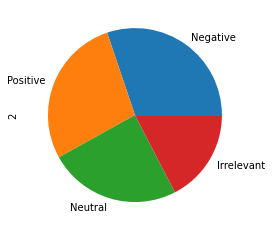

In [ ]:
# Here is the distribution of classes
y.value_counts().plot(kind='pie')

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# loading the stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# loading the lemmatizer
from nltk.stem import WordNetLemmatizer
lzr = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aswathy\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aswathy\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswathy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aswathy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [ ]:
import re
from string import punctuation
from nltk.tokenize import word_tokenize

def text_processing(text):
    # convert text into lowercase
    text = text.lower()

    # remove new line characters in text
    text = re.sub(r'\n',' ', text)

    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)

    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)

    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # remove special characters from text
    text = re.sub(r'\W', ' ', text)

    # tokenize the words using nltk word tokenizer and remove the stop words using nltk package's english stop words
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    # lemmatizer using WordNetLemmatizer from nltk package
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [ ]:
# Making the copy of the dataset to apply the function over it
data_copy = df.copy()
data_copy.iloc[:,-1] = data_copy.iloc[:,-1].astype(str).apply(lambda text: text_processing(text))

In [ ]:
# Encoding the target label into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_copy.iloc[:,-2] = le.fit_transform(data_copy.iloc[:,-2])
data_copy.head()

,0,1,2,3
0,2401,Borderlands,3,im getting borderland murder
1,2401,Borderlands,3,coming border kill
2,2401,Borderlands,3,im getting borderland kill
3,2401,Borderlands,3,im coming borderland murder
4,2401,Borderlands,3,im getting borderland 2 murder


In [ ]:
# Here is the arrangment of classes
le.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

## Balancing Classes

In [ ]:
# Balancing the classes
from sklearn.utils import resample

df_irrelevant = data_copy[(data_copy.iloc[:,-2]==0)]
df_negative = data_copy[(data_copy.iloc[:,-2]==1)]
df_neutral = data_copy[(data_copy.iloc[:,-2]==2)]
df_positive = data_copy[(data_copy.iloc[:,-2]==3)]

# upsample minority classes
df_irrelevant_upsampled = resample(df_irrelevant,
                                    replace=True,
                                    n_samples= 22542,
                                    random_state=42)

df_positive_upsampled = resample(df_positive,
                                 replace=True,
                                 n_samples= 22542,
                                 random_state=42)

df_neutral_upsampled = resample(df_neutral,
                                 replace=True,
                                 n_samples= 22542,
                                 random_state=42)


# Concatenate the upsampled dataframes with the neutral dataframe
final_data = pd.concat([df_irrelevant_upsampled, df_positive_upsampled, df_neutral_upsampled, df_negative])
final_data.iloc[:,-2].value_counts()

0    22542
3    22542
2    22542
1    22542
Name: 2, dtype: int64

<AxesSubplot:>

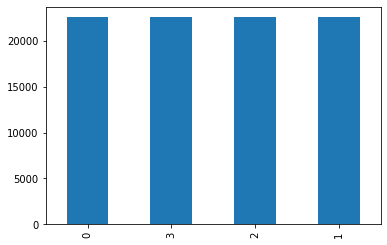

In [ ]:
# Here the dataset is balanced now
final_data.iloc[:,-2].value_counts().plot(kind='bar')

In [ ]:


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

# The Embedding dimension
EMBEDDING_DIM = 100

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# First tokenize all the input data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(final_data.iloc[:,-1].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35213 unique tokens.


In [ ]:
# Then make it into tensor format for further application of model training
X_final = tokenizer.texts_to_sequences(final_data.iloc[:,-1].values)
X_final = pad_sequences(X_final, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_final.shape)

Y_final = pd.get_dummies(final_data.iloc[:,-2]).values
print('Shape of label tensor:', Y_final.shape)

Shape of data tensor: (90168, 250)
Shape of label tensor: (90168, 4)


# Task 2:Seperating the train and test data for the training

In [ ]:
# Seperate the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size = 0.3, random_state = 42, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(63117, 250) (63117, 4)
(27051, 250) (27051, 4)


Task 3-RNN method implementation

In [ ]:
# Create a model for the textual data training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D

rnn_model = Sequential()
rnn_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_final.shape[1]))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(4, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

rnn_history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test))

Epoch 1/5
987/987 [==============================] - 347s 348ms/step - loss: 1.1128 - accuracy: 0.5055 - val_loss: 1.0273 - val_accuracy: 0.6699
Epoch 2/5
987/987 [==============================] - 355s 359ms/step - loss: 0.7691 - accuracy: 0.7063 - val_loss: 0.6275 - val_accuracy: 0.7670
Epoch 3/5
987/987 [==============================] - 373s 378ms/step - loss: 0.6836 - accuracy: 0.7390 - val_loss: 0.8223 - val_accuracy: 0.6652
Epoch 4/5
987/987 [==============================] - 338s 342ms/step - loss: 0.6354 - accuracy: 0.7515 - val_loss: 0.5634 - val_accuracy: 0.7912
Epoch 5/5
987/987 [==============================] - 330s 334ms/step - loss: 0.4658 - accuracy: 0.8248 - val_loss: 0.4834 - val_accuracy: 0.8255


In [ ]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 5,029,828
Trainable params: 5,029,828
Non-trainable params: 0
_________________________________________________________________


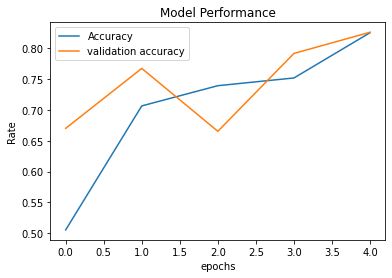

In [ ]:
import matplotlib.pyplot as plt

# Model Performance graph
plt.plot(range(epochs), rnn_history.history['accuracy'], label = "Accuracy")
plt.plot(range(epochs), rnn_history.history['val_accuracy'], label = "validation accuracy")
plt.title("Model Performance")
plt.xlabel("epochs")
plt.ylabel("Rate")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Getting the actual and predicted values
y_actual = [np.argmax(i) for i in Y_test]
y_pred = [np.argmax(i) for i in rnn_model.predict(X_test)]

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score

# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True, fmt='g',cmap='viridis')
    plt.tight_layout()
    plt.show()

========== RNN Model ==========

Accuracy on validation set: 0.8255

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      6707
           1       0.77      0.85      0.81      6692
           2       0.86      0.79      0.82      6747
           3       0.78      0.85      0.81      6905

    accuracy                           0.83     27051
   macro avg       0.83      0.83      0.83     27051
weighted avg       0.83      0.83      0.83     27051


Confusion Matrix : 
 [[5477  495  206  529]
 [ 202 5678  330  482]
 [ 138  647 5336  626]
 [ 180  559  327 5839]]


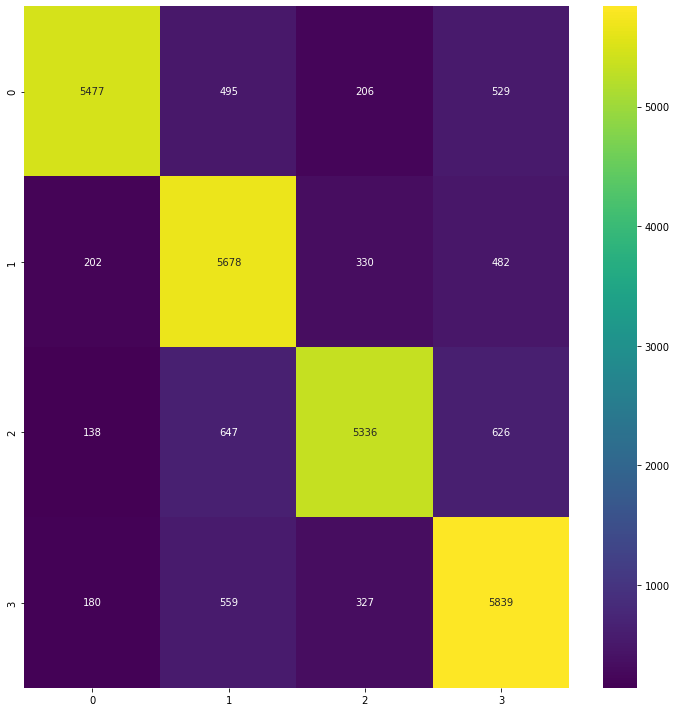

In [ ]:
modelEvaluation(y_pred, y_actual, "RNN Model")